In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SequentialFeatureSelector
#from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
# Import training data
train_df = pd.read_csv("C:/Users/peiha/Documents/GitHub/ApplyAIGroupProject/new_train.csv")
train_df.head(2)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,6,State_6,Residential,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,...,96,17,0,0,NaN,NaN,NaN,131.0,2.493169,62149
1,5,State_6,Residential,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,...,106,12,0,0,330.0,340.0,18.3,148.0,103.520536,51736


In [3]:
print("Number of rows in training dataset:", len(train_df))

Number of rows in training dataset: 68181


In [4]:
# Import test data
test_df = pd.read_csv("C:/Users/peiha/Documents/GitHub/ApplyAIGroupProject/new_test.csv")
test_df.head(2)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
1,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5


In [5]:
print("Number of rows in test dataset:", len(test_df))

Number of rows in test dataset: 7576


In [6]:
# Briefly explore the training data
#train_df.info()

In [7]:
# Get NaN values on each column
train_df.isna().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    37662
max_wind_speed               36993
days_with_fog                41147
site_eui                         0
id                               0
Length: 64, dtype: int64

In [8]:
#pull numeric features
df_with_numeric_features = train_df.select_dtypes(exclude=['object'])
#print("Numeric features:")
#for col in df_with_numeric_features:
#    print(f"{col}")

In [9]:
# Pull non-numeric features
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [10]:
# Remove duplicates
column_names = train_df.columns.tolist()
#column_names

In [11]:
column_names.remove('id')

train_df.drop_duplicates(subset=column_names, keep='last', inplace=True)
print("Number of rows after removing duplicates", len(train_df))

Number of rows after removing duplicates 68148


In [12]:
# Fix structural errors
df_with_non_numeric_features.columns

Index(['State_Factor', 'building_class', 'facility_type'], dtype='object')

In [13]:
#train_df['facility_type'].value_counts()

In [14]:
# Convert to lower case
# train_df['facility_type'] = train_df['facility_type'].str.lower()
# train_df['facility_type'].value_counts()

In [15]:
# Check the range of values
#print("Numeric features:")
#for col in df_with_numeric_features:
#    print(f"{col}")

In [16]:
# Filter outliers

features_considered = ['Year_Factor', 'floor_area','year_built', 'energy_star_rating', 'ELEVATION','cooling_degree_days',\
                       'heating_degree_days','avg_temp','site_eui']
# calculate z-scores for numeric features
z_scores = zscore(train_df[features_considered], nan_policy='omit')
#z_scores

In [17]:
# convert to absolute values
abs_z_scores = np.abs(z_scores)
# filter based on |z-score| less than 3
filtered_entries = (abs_z_scores < 3).all(axis=1)
filtered_entries

array([ True,  True, False, ..., False, False, False])

In [18]:
print("Outliers present in the dataset")
train_df.loc[filtered_entries == False]

Outliers present in the dataset


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
2,3,State_6,Residential,Multifamily_Uncategorized,212671.0,2010.0,NaN,42.7,11,35.080645,...,75,11,0,0,310.0,320.0,13.4,63.0,39.590324,30363
4,3,State_8,Commercial,Grocery_store_or_food_market,50388.0,1998.0,48.0,18.3,4,32.903226,...,86,16,0,0,NaN,NaN,NaN,NaN,268.315452,66132
7,3,State_6,Residential,Multifamily_Uncategorized,85404.0,1928.0,NaN,11.9,11,35.080645,...,75,11,0,0,NaN,NaN,NaN,NaN,94.714555,32710
9,3,State_6,Residential,Multifamily_Uncategorized,60492.0,1940.0,NaN,11.9,11,35.080645,...,75,11,0,0,NaN,NaN,NaN,NaN,76.133629,25248
10,5,State_6,Residential,Multifamily_Uncategorized,120079.0,1928.0,NaN,15.2,8,29.854839,...,106,12,0,0,NaN,NaN,NaN,NaN,36.144538,45702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68172,2,State_6,Residential,Multifamily_Uncategorized,75560.0,1959.0,NaN,3.4,13,37.322581,...,72,17,0,0,1.0,1.0,1.0,79.0,113.090164,21648
68173,6,State_4,Commercial,Education_College_or_university,59287.0,1985.0,NaN,198.1,-2,25.166667,...,113,40,0,0,NaN,NaN,NaN,NaN,113.071541,12477
68178,2,State_6,Residential,Multifamily_Uncategorized,582822.0,1986.0,NaN,42.7,13,37.322581,...,72,17,0,0,1.0,1.0,1.0,99.0,74.543433,18653
68179,2,State_6,Residential,Multifamily_Uncategorized,105681.0,1928.0,NaN,42.7,13,37.322581,...,72,17,0,0,1.0,1.0,1.0,99.0,84.088746,22956


In [19]:
df_without_outliers = train_df[filtered_entries]
print('Number of rows after filtering outliers:', len(df_without_outliers))
train_df = df_without_outliers;
df_without_outliers.head()

Number of rows after filtering outliers: 40062


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,6,State_6,Residential,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,...,96,17,0,0,NaN,NaN,NaN,131.0,2.493169,62149
1,5,State_6,Residential,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,...,106,12,0,0,330.0,340.0,18.3,148.0,103.520536,51736
3,6,State_11,Residential,2to4_Unit_Building,51294.0,1908.0,79.0,26.5,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,31.998135,74562
5,6,State_8,Commercial,Education_Other_classroom,90000.0,1965.0,93.0,21.3,8,29.827586,...,101,21,0,0,NaN,NaN,NaN,NaN,45.804787,69267
6,4,State_6,Commercial,Nursing_Home,85835.0,1971.0,16.0,42.7,4,28.596774,...,75,4,0,0,1.0,1.0,1.0,NaN,163.085921,42243


In [20]:
# Handle missing values

#Find columns which have missing values
train_df.isna().sum()[train_df.isna().sum()>0]
#pd.set_option('display.max_rows', None)
#train_df.isna().sum()

direction_max_wind_speed     21492
direction_peak_wind_speed    22001
max_wind_speed               21492
days_with_fog                24987
dtype: int64

In [21]:
#Delete columns that have missing values
train_df = train_df.drop(columns=['id','direction_max_wind_speed','direction_peak_wind_speed',\
                                  'max_wind_speed','days_with_fog'])

In [22]:
#Delete rows that have missing values
#train_df = train_df.dropna(subset = ['id','direction_max_wind_speed','direction_peak_wind_speed',\
#                                     'max_wind_speed','days_with_fog']).reset_index(drop = True)

In [23]:
# get count of missing value in train_df
train_df.columns[train_df.isna().any()].tolist()

[]

In [24]:
print("Number of rows in training data after filtering missing values:", len(train_df))
train_df.head()

Number of rows in training data after filtering missing values: 40062


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,6,State_6,Residential,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,...,57.215847,40,11,2,1,96,17,0,0,2.493169
1,5,State_6,Residential,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,...,56.835616,63,34,9,0,106,12,0,0,103.520536
3,6,State_11,Residential,2to4_Unit_Building,51294.0,1908.0,79.0,26.5,28,43.451613,...,55.147541,6,0,0,0,25,3,0,0,31.998135
5,6,State_8,Commercial,Education_Other_classroom,90000.0,1965.0,93.0,21.3,8,29.827586,...,53.839335,97,29,6,0,101,21,0,0,45.804787
6,4,State_6,Commercial,Nursing_Home,85835.0,1971.0,16.0,42.7,4,28.596774,...,54.501370,66,24,7,0,75,4,0,0,163.085921


In [25]:
# Do the same for the test data
test_df.isna().sum()[test_df.isna().sum()>0]

year_built                    172
energy_star_rating           2626
direction_max_wind_speed     4089
direction_peak_wind_speed    4149
max_wind_speed               4089
days_with_fog                4649
dtype: int64

In [26]:
#Delete columns that have missing values
test_df = test_df.drop(columns=['id','direction_max_wind_speed','direction_peak_wind_speed',\
                                  'max_wind_speed','days_with_fog'])
#Delete rows that have missing values
test_df = test_df.dropna(subset = ['year_built','energy_star_rating']).reset_index(drop = True)

In [27]:
print("Number of rows in testing data after filtering missing values:", len(test_df))
test_df.head()

Number of rows in testing data after filtering missing values: 4877


,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,3.899395
1,1,State_1,Commercial,Office_Uncategorized,108000.0,1902.0,98.0,59.1,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,33.693485
2,1,State_1,Commercial,Office_Uncategorized,117200.0,1920.0,57.0,59.1,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,89.339645
3,1,State_1,Commercial,Office_Uncategorized,295114.0,1989.0,54.0,59.1,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,118.112437
4,1,State_1,Commercial,Office_Uncategorized,1011213.0,1920.0,70.0,59.1,36,50.5,...,56.972603,0,0,0,0,14,0,0,0,142.478168


In [28]:
# Fill in values with a specific values (imputation)
#train_df.year_built.plot()

In [29]:
numeric_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('site_eui')
cor_matrix = train_df[numeric_features + ['site_eui']].corr()
#cor_matrix

In [30]:
#plt.figure(figsize = (20,20))
#sns.heatmap(cor_matrix, annot = True)

In [31]:
#cor_matrix['site_eui'].abs() > 0.2

In [32]:
features_with_higher_cor_to_target = cor_matrix['site_eui'][cor_matrix['site_eui'].abs() > 0.2].index.tolist()
features_with_higher_cor_to_target.remove('site_eui')
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'march_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_above_80F']


In [33]:
# Mutual Info Regression
#numeric_features = np.array(numeric_features)
#m_info = mutual_info_regression(train_df[numeric_features], train_df['site_eui'], \
#                                discrete_features=[0, 3, 4, 6], n_neighbors=5)
#features_with_higher_mutual_info = numeric_features[m_info>0.2]
#print("Features selected ", features_with_higher_mutual_info)

In [34]:
# Convert categorical variables to numerical

# grab non-numeric features
df_with_non_numeric_features = train_df.select_dtypes(include=['object'])
print("Non-numeric columns:")
for col in df_with_non_numeric_features:
    print(f"{col}")

Non-numeric columns:
State_Factor
building_class
facility_type


In [35]:
train_df['State_Factor'].value_counts()

State_6     26345
State_11     4234
State_2      3344
State_4      2565
State_8      1851
State_1      1715
State_10        8
Name: State_Factor, dtype: int64

In [36]:
train_df['building_class'].value_counts()

Residential    22877
Commercial     17185
Name: building_class, dtype: int64

In [37]:
#train_df['facility_type'].value_counts()

In [38]:
# OneHotEncoding 'State_Factor'
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore')

In [39]:
# Create a Pandas DataFrame of the hot encoded column
transformed = encoder.transform(np.array(train_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_train = pd.DataFrame(transformed, columns=encoder.get_feature_names())

In [40]:
# Concat with original data
train_df.reset_index(drop=True, inplace=True)
ohe_df_train.reset_index(drop=True, inplace=True)

train_df = pd.concat([train_df, ohe_df_train], axis=1)
train_df = train_df.drop(['State_Factor'], axis=1)
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,6,Residential,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,59,...,0,0,2.493169,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,Residential,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,56,...,0,0,103.520536,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6,Residential,2to4_Unit_Building,51294.0,1908.0,79.0,26.5,28,43.451613,56,...,0,0,31.998135,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6,Commercial,Education_Other_classroom,90000.0,1965.0,93.0,21.3,8,29.827586,62,...,0,0,45.804787,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,Commercial,Nursing_Home,85835.0,1971.0,16.0,42.7,4,28.596774,58,...,0,0,163.085921,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
# Perform the same on test data
transformed = encoder.transform(np.array(test_df['State_Factor'].tolist()).reshape(-1, 1)).toarray()
ohe_df_test = pd.DataFrame(transformed, columns=encoder.get_feature_names())

test_df = pd.concat([test_df, ohe_df_test], axis=1)
test_df = test_df.drop(['State_Factor'], axis=1)
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,...,0,0,3.899395,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Commercial,Office_Uncategorized,108000.0,1902.0,98.0,59.1,36,50.5,68,...,0,0,33.693485,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Commercial,Office_Uncategorized,117200.0,1920.0,57.0,59.1,36,50.5,68,...,0,0,89.339645,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,Commercial,Office_Uncategorized,295114.0,1989.0,54.0,59.1,36,50.5,68,...,0,0,118.112437,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,Commercial,Office_Uncategorized,1011213.0,1920.0,70.0,59.1,36,50.5,68,...,0,0,142.478168,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Encode ordinal values

encode_categorical_values = {"Residential":0, "Commercial":1}
train_df['building_class'] = train_df['building_class'].replace(encode_categorical_values) 
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,6,0,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,59,...,0,0,2.493169,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,0,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,56,...,0,0,103.520536,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6,0,2to4_Unit_Building,51294.0,1908.0,79.0,26.5,28,43.451613,56,...,0,0,31.998135,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6,1,Education_Other_classroom,90000.0,1965.0,93.0,21.3,8,29.827586,62,...,0,0,45.804787,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1,Nursing_Home,85835.0,1971.0,16.0,42.7,4,28.596774,58,...,0,0,163.085921,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
# Perform the same on test data
encode_categorical_values = {"Residential":0, "Commercial":1}
test_df['building_class'] = test_df['building_class'].replace(encode_categorical_values) 
test_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,1,1,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,...,0,0,3.899395,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,Office_Uncategorized,108000.0,1902.0,98.0,59.1,36,50.5,68,...,0,0,33.693485,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,Office_Uncategorized,117200.0,1920.0,57.0,59.1,36,50.5,68,...,0,0,89.339645,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,Office_Uncategorized,295114.0,1989.0,54.0,59.1,36,50.5,68,...,0,0,118.112437,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,Office_Uncategorized,1011213.0,1920.0,70.0,59.1,36,50.5,68,...,0,0,142.478168,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Log Transformation
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'march_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_above_80F']


In [45]:
#ax = sns.displot(train_df['site_eui'])

In [46]:
#sns.displot(np.log(train_df.loc[train_df['site_eui']!=0, 'site_eui']))
train_df.head()

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,6,0,Multifamily_Uncategorized,77000.0,1924.0,100.0,42.7,11,34.451613,59,...,0,0,2.493169,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5,0,Multifamily_Uncategorized,66595.0,1925.0,46.0,25.6,8,29.854839,56,...,0,0,103.520536,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6,0,2to4_Unit_Building,51294.0,1908.0,79.0,26.5,28,43.451613,56,...,0,0,31.998135,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6,1,Education_Other_classroom,90000.0,1965.0,93.0,21.3,8,29.827586,62,...,0,0,45.804787,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,1,Nursing_Home,85835.0,1971.0,16.0,42.7,4,28.596774,58,...,0,0,163.085921,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [47]:
# Scaling and Normalization

#Standardization (transform to mean=0, sd=1)
scaler = StandardScaler()
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,0.909886,-0.483815,-0.906065,1.365869,0.104966,0.069002,0.216494,0.270279,-0.822881,0.410340,...,-0.562430,0.733135,-0.489802,-0.653057,-0.598833,0.053493,0.427613,0.387590,-0.146612,0.0
1,0.118744,-0.556497,-0.875243,-0.526126,-0.245714,-0.272825,-0.518233,-0.446422,-0.571673,-1.227899,...,1.431954,0.510888,0.394575,1.020978,0.496043,-0.345803,0.828373,-0.147653,-0.146612,0.0
2,0.909886,-0.663377,-1.399218,0.630093,-0.227257,2.006021,1.655010,-0.446422,2.107876,1.596776,...,-1.113365,-0.475802,-1.797141,-1.453682,-0.911655,-0.345803,-2.417776,-1.111091,-0.146612,0.0
3,0.909886,-0.393007,0.357641,1.120610,-0.333896,-0.272825,-0.522589,0.986980,-0.404201,-0.043297,...,-1.019706,-1.240456,1.701915,0.657057,0.026810,-0.345803,0.627993,0.815784,-0.146612,0.0
4,-0.672397,-0.422101,0.542573,-1.577235,0.104966,-0.728594,-0.719316,0.031379,0.014479,-0.313734,...,0.958150,-0.853493,0.509929,0.293137,0.183221,-0.345803,-0.413981,-1.004042,-0.146612,0.0


In [48]:
#Perform the same on the test data (HINT: don't refit the transform)
scaler = StandardScaler()
test_df[numeric_features] = scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,-3.066168,-0.437115,0.716406,1.363704,-0.693333,2.610642,2.407302,1.842358,2.02055,1.751247,...,-1.086746,0.435392,-1.885573,-1.349004,-0.831143,-0.345041,-2.789636,-1.343631,-0.156018,0.0
1,-3.066168,-0.268346,-1.211570,1.293846,0.286671,2.610642,2.407302,1.842358,2.02055,1.751247,...,-1.086746,0.435392,-1.885573,-1.349004,-0.831143,-0.345041,-2.789636,-1.343631,-0.156018,0.0
2,-3.066168,-0.231377,-0.793455,-0.138240,0.286671,2.610642,2.407302,1.842358,2.02055,1.751247,...,-1.086746,0.435392,-1.885573,-1.349004,-0.831143,-0.345041,-2.789636,-1.343631,-0.156018,0.0
3,-3.066168,0.483539,0.809320,-0.243027,0.286671,2.610642,2.407302,1.842358,2.02055,1.751247,...,-1.086746,0.435392,-1.885573,-1.349004,-0.831143,-0.345041,-2.789636,-1.343631,-0.156018,0.0
4,-3.066168,3.361058,-0.793455,0.315836,0.286671,2.610642,2.407302,1.842358,2.02055,1.751247,...,-1.086746,0.435392,-1.885573,-1.349004,-0.831143,-0.345041,-2.789636,-1.343631,-0.156018,0.0


In [49]:
#Normalization through Min/Max scaling
min_max_scaler = MinMaxScaler()
train_df[numeric_features] = min_max_scaler.fit_transform(train_df[numeric_features])
train_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,1.0,0.082518,0.464706,1.000000,0.187615,0.446809,0.427921,0.566667,0.218182,0.548987,...,0.190566,0.699230,0.322581,0.186441,0.055556,0.05,0.732143,0.326923,0.0,0.0
1,0.8,0.071009,0.470588,0.454545,0.109174,0.382979,0.283763,0.466667,0.272727,0.226445,...,0.873585,0.663378,0.508065,0.576271,0.250000,0.00,0.821429,0.230769,0.0,0.0
2,1.0,0.054086,0.370588,0.787879,0.113303,0.808511,0.710167,0.466667,0.854545,0.782576,...,0.001887,0.504212,0.048387,0.000000,0.000000,0.00,0.098214,0.057692,0.0,0.0
3,1.0,0.096897,0.705882,0.929293,0.089450,0.382979,0.282909,0.666667,0.309091,0.459673,...,0.033962,0.380863,0.782258,0.491525,0.166667,0.00,0.776786,0.403846,0.0,0.0
4,0.6,0.092290,0.741176,0.151515,0.187615,0.297872,0.244310,0.533333,0.400000,0.406429,...,0.711321,0.443286,0.532258,0.406780,0.194444,0.00,0.544643,0.076923,0.0,0.0


In [50]:
#Perform the same on the test data
min_max_scaler = MinMaxScaler()
test_df[numeric_features] = min_max_scaler.fit_transform(test_df[numeric_features])
test_df[numeric_features].head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,0.0,0.014166,0.985112,1.000000,0.001928,0.916667,0.896213,0.742857,0.872727,0.85448,...,0.0,0.659752,0.0,0.0,0.0,0.0,0.061538,0.0,0.0,0.0
1,0.0,0.024427,0.943921,0.979798,0.184126,0.916667,0.896213,0.742857,0.872727,0.85448,...,0.0,0.659752,0.0,0.0,0.0,0.0,0.061538,0.0,0.0,0.0
2,0.0,0.026675,0.952854,0.565657,0.184126,0.916667,0.896213,0.742857,0.872727,0.85448,...,0.0,0.659752,0.0,0.0,0.0,0.0,0.061538,0.0,0.0,0.0
3,0.0,0.070143,0.987097,0.535354,0.184126,0.916667,0.896213,0.742857,0.872727,0.85448,...,0.0,0.659752,0.0,0.0,0.0,0.0,0.061538,0.0,0.0,0.0
4,0.0,0.245100,0.952854,0.696970,0.184126,0.916667,0.896213,0.742857,0.872727,0.85448,...,0.0,0.659752,0.0,0.0,0.0,0.0,0.061538,0.0,0.0,0.0


In [51]:
train_df.isna().sum()[train_df.isna().sum()>0]

Series([], dtype: int64)

In [52]:
# Dimensionality Reduction using PCA

# Split the training data and test data from train_df with 8:2 using scikit-learn
#training_data, testing_data = train_test_split(train_df, test_size=0.2, random_state=25)

print(f"No. of training examples: {train_df.shape[0]}")
print(f"No. of testing examples: {test_df.shape[0]}")

No. of training examples: 40062
No. of testing examples: 4877


In [53]:
y_train = train_df['site_eui']
X_train = train_df.drop(columns = ['site_eui','facility_type'])
# same for test data
y_test = test_df['site_eui']
X_test = test_df.drop(columns = ['site_eui','facility_type'])

In [54]:
lr_classifier = LinearRegression()
lr_classifier.fit(X_train, y_train)

LinearRegression()

In [55]:
y_pred = lr_classifier.predict(X_test)
print("MSE", mean_squared_error(y_test, y_pred))

MSE 8.732443091160192e+26


In [56]:
performance_across_n_comp = []
for n_components in range(1, len(train_df.columns) - 2):
    pca = PCA(n_components)
    pca.fit(X_train)
    X_train_transformed = pca.transform(X_train)
    X_test_transformed = pca.transform(X_test)

    lr_classifier = LinearRegression()
    lr_classifier.fit(X_train_transformed, y_train)
    y_pred_i = lr_classifier.predict(X_test_transformed)
    performance_across_n_comp.append(mean_squared_error(y_test, y_pred_i))

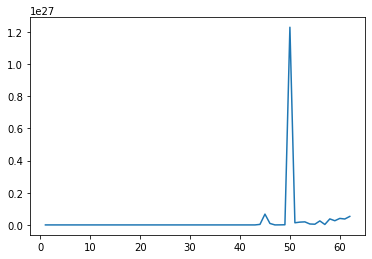

In [57]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)

In [58]:
# compare MSE of full model to PCA regression with 16 components
abs(performance_across_n_comp[15] - mean_squared_error(y_test, y_pred))

8.732443091160192e+26

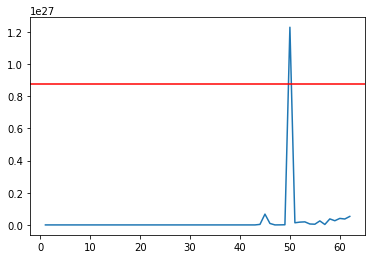

In [59]:
plt.plot(list(range(1, len(train_df.columns) - 2)), performance_across_n_comp)
plt.axhline(y=mean_squared_error(y_test, y_pred), color='r', linestyle='-')